In [1]:
import numpy as np
import pandas as pd
import math
import scipy as sp
import netCDF4
import gsw # this will be VERY useful https://github.com/TEOS-10/GSW-Python

# 1. Download synthetic argo file (= S-file)

In [2]:
# import requests
# import urllib 
# import ftplib
import wget
import os

def download_float(dac, wmo):
    """
    dac : data center, e.g. 'coriolis'
    wmo : world id of the float (unique), e.g. 6901866
    """
    
    # check if float folder exists
    if(os.path.isdir('./floats') == False):
        print("Directory 'floats' does not exist")
        print("It's being created in your current path")
        os.mkdir(os.path.join(os.getcwd(),'floats'))
    # check if file already exists in that folder
    if(os.path.isfile(os.getcwd()+'/floats/'+str(wmo)+'_Sprof.nc') == False):
        print("File does not exist")
        print("File is being downloaded")
        print("...")
        base_url = 'ftp://ftp.ifremer.fr/ifremer/argo/dac/'
        full_url = base_url+dac+'/'+str(wmo)+'/'
        link = full_url+str(wmo)+'_Sprof.nc'
        wget.download(link, out = os.getcwd()+'/floats/')
        print("Done !")
    else:
        print("File already exists, moving on.")

In [3]:
download_float('coriolis',6900798)
#download_float('coriolis',6901866) # Black Sea, just for testing
#download_float('coriolis',6900799)

File already exists, moving on.


# 2. Extract data from NetCDF

In [4]:
# Read data

def read_data(wmo):
    
    ncfile = str(wmo)+'_Sprof.nc'
    # see also the doc for SYNTHETIC BGC-ARGO files: https://archimer.ifremer.fr/doc/00445/55637/75359.pdf
    nc = netCDF4.Dataset(os.getcwd()+'/floats/'+ncfile, mode='r') # add a get url download the file in a folder then read it
    # get coordinates variables
    lat = nc.variables['LATITUDE'][:].data
    lon = nc.variables['LONGITUDE'][:].data
    time = nc.variables['JULD'][:].data
    depth = nc.variables['PRES'][:].data
    depth_qc = nc.variables['PRES_QC'][:].data
    
    #other parameters
    bbp = nc.variables['BBP700'][:].data
    bbp_qc = nc.variables['BBP700_QC'][:].data
    chla = nc.variables['CHLA'][:].data
    chla_qc = nc.variables['CHLA_QC'][:].data
    temp = nc.variables['TEMP'][:].data
    temp_qc = nc.variables['TEMP_QC'][:].data
    psal = nc.variables['PSAL'][:].data
    psal_qc = nc.variables['PSAL_QC'][:].data
    
    # close netcdf
    nc.close()
    
    # put data into a Dataframe
    data = pd.DataFrame({'depth':np.concatenate(depth), 'depth_qc':np.concatenate(depth_qc), 'temp':np.concatenate(temp),
              'temp_qc':np.concatenate(temp_qc), 'psal':np.concatenate(psal), 'psal_qc':np.concatenate(psal_qc),
              'chla':np.concatenate(chla), 'chla_qc':np.concatenate(chla_qc), 'bbp':np.concatenate(bbp), 
              'bbp_qc':np.concatenate(bbp_qc)})
    
    # number of profiles in the file
    n_prof = len(time)
    
    # repeat metadata to fit data length
    points_per_profile = data.shape[0]/n_prof
    time = np.repeat(time, points_per_profile)
    lat = np.repeat(lat, points_per_profile)
    lon = np.repeat(lon, points_per_profile)
    data['time'] = time
    data['lat'] = lat
    data['lon'] = lon

    # add WMO
    data['wmo'] = wmo
    
    # add profile IDs in a similar way, assuming the hypothesis of constant length per profile is correct (thanks to S profiles?)
    ids = np.array(range(1,n_prof+1))
    data['id'] = np.repeat(ids, points_per_profile)
    
    # some additional cleaning
    FillValue = 99999.0
    data = data.replace(FillValue, 'NaN')
    
    return(data)

In [5]:
# choose the float
wmo = 6900798
wmo = 6900799

In [6]:
data = read_data(wmo)
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,wmo,id
0,4.1,b'1',7.328,b'1',35.239,b'1',NaN,b' ',NaN,b' ',22223.943646,70.030,6.017,6900799,1
1,6,b'1',7.332,b'1',35.239,b'1',0.0792,b'3',0.000568973,b'2',22223.943646,70.030,6.017,6900799,1
2,8.1,b'1',7.336,b'1',35.239,b'1',NaN,b' ',NaN,b' ',22223.943646,70.030,6.017,6900799,1
3,10,b'1',7.335,b'1',35.239,b'1',0.0651882,b'3',0.000557633,b'2',22223.943646,70.030,6.017,6900799,1
4,12,b'1',7.335,b'1',35.239,b'1',NaN,b' ',NaN,b' ',22223.943646,70.030,6.017,6900799,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106543,NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',23273.949641,71.147,5.378,6900799,156
106544,NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',23273.949641,71.147,5.378,6900799,156
106545,NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',23273.949641,71.147,5.378,6900799,156
106546,NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',23273.949641,71.147,5.378,6900799,156


# 3. Some data cleaning
- convert QC bytes into integers
- remove depth where we don't have BBP data ==> this needs to be validated and check the order with the additional QCs to be applied

In [7]:
# convert QC bytes into integers
def bytes_to_int(x):
    try:
        x = int(x)
    except:
        x = 'NaN'
    return(x)

In [8]:
# apply that function where it is needed
data['temp_qc'] = data['temp_qc'].apply(bytes_to_int)
data['psal_qc'] = data['psal_qc'].apply(bytes_to_int)
data['depth_qc'] = data['depth_qc'].apply(bytes_to_int)
data['chla_qc'] = data['chla_qc'].apply(bytes_to_int)
data['bbp_qc'] = data['bbp_qc'].apply(bytes_to_int)

In [9]:
# remove negative NaN depth and negative depths
data['depth_qc'].replace(3, 'NaN', inplace=True)
data['depth_qc'].replace(4, 'NaN', inplace=True)
data = data[data.depth != 'NaN']
data = data[data.depth >= 0]

In [10]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,wmo,id
0,4.1,1,7.328,1,35.239,1,NaN,NaN,NaN,NaN,22223.943646,70.030,6.017,6900799,1
1,6,1,7.332,1,35.239,1,0.0792,3,0.000568973,2,22223.943646,70.030,6.017,6900799,1
2,8.1,1,7.336,1,35.239,1,NaN,NaN,NaN,NaN,22223.943646,70.030,6.017,6900799,1
3,10,1,7.335,1,35.239,1,0.0651882,3,0.000557633,2,22223.943646,70.030,6.017,6900799,1
4,12,1,7.335,1,35.239,1,NaN,NaN,NaN,NaN,22223.943646,70.030,6.017,6900799,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106535,1200,1,-0.354,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156
106536,1202,1,-0.354,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156
106537,1204,1,-0.355,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156
106538,1206,1,-0.357,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156


In [11]:
# convert time to HUMAN time
import datetime
def julian_to_human(group):
    gregorian_time = datetime.date(1950, 1, 1) + datetime.timedelta(days=np.min(group['time']))
    #group['human_time'] = np.repeat(gregorian_time.strftime('%d-%m-%Y'), group.shape[0])
    group['human_time'] = np.repeat(gregorian_time, group.shape[0])
    return(group)

data = data.groupby('id').apply(julian_to_human)

# 4. Quality controls (Giorgio didn't use any ? -> yes)

In [12]:
# to be done : apply some additionnal QC on BBP data
# QUESTION: before of after removing the NaN (if needed) => see below

# QC from https://archimer.ifremer.fr/doc/00491/60262/63668.pdf

# let's apply those from ARGO
# replace QC 3 & 4 with NaN
data['temp_qc'].replace(3, 'NaN', inplace=True)
data['temp_qc'].replace(4, 'NaN', inplace=True)
data['psal_qc'].replace(3, 'NaN', inplace=True)
data['psal_qc'].replace(4, 'NaN', inplace=True)
data['bbp_qc'].replace(3, 'NaN', inplace=True)
data['bbp_qc'].replace(4, 'NaN', inplace=True)
data['chla_qc'].replace(3, 'NaN', inplace=True)
data['chla_qc'].replace(4, 'NaN', inplace=True)

In [13]:
data = data[data.temp_qc != 'NaN']
data = data[data.psal_qc != 'NaN']
#data = data[data.bbp_qc != 'NaN'] # will be applied AFTER the computation of the MLD
# I am not applying the QC on chla on purpose because I know that Chla QC is very tricky .. we could lose entire profiles
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,wmo,id,human_time
0,4.1,1,7.328,1,35.239,1,NaN,NaN,NaN,NaN,22223.943646,70.030,6.017,6900799,1,2010-11-05
1,6,1,7.332,1,35.239,1,0.0792,NaN,0.000568973,2,22223.943646,70.030,6.017,6900799,1,2010-11-05
2,8.1,1,7.336,1,35.239,1,NaN,NaN,NaN,NaN,22223.943646,70.030,6.017,6900799,1,2010-11-05
3,10,1,7.335,1,35.239,1,0.0651882,NaN,0.000557633,2,22223.943646,70.030,6.017,6900799,1,2010-11-05
4,12,1,7.335,1,35.239,1,NaN,NaN,NaN,NaN,22223.943646,70.030,6.017,6900799,1,2010-11-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106535,1200,1,-0.354,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156,2013-09-20
106536,1202,1,-0.354,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156,2013-09-20
106537,1204,1,-0.355,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156,2013-09-20
106538,1206,1,-0.357,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156,2013-09-20


# 5. Compute density

In [14]:
# compute density
# see https://teos-10.github.io/GSW-Python/
psal = gsw.SA_from_SP(np.array(data['psal']), np.array(data['depth']), np.array(data['lon']), np.array(data['lat']))
temp = gsw.CT_from_t(psal, np.array(data['temp']), np.array(data['depth']))
sigma = gsw.sigma0(psal, temp)
data['sigma'] = sigma

# 6. Let's smoothe the density before computing the MLD
- Apply a median filter with a kernel size of 5
- Apply a 1D filter (check if this is a running moving one on scipy..)

In [15]:
from scipy import signal
from scipy.ndimage import uniform_filter1d

def medianfilter_sigma(group):
    smoothed = signal.medfilt(group['sigma'],11) # kernel size = 5 ==> 11 (see email of Giorgio)
    group['sigma'] = smoothed
    return(group)

def moving_average_filter(group): # check that is is indeed a moving average filter..
    smoothed = uniform_filter1d(np.array(group['sigma']), size = 7) # I think I can remove the np.array()
    group['sigma'] = smoothed
    return(group)
    
# apply filters
data = data.groupby('id').apply(medianfilter_sigma)
data = data.groupby('id').apply(moving_average_filter)

In [16]:
# # Let's start with the shape of the Chla profile
# # plot some data
# tmp = data[data.id == 77] # choose a profil ID here 
# tmp = tmp[tmp.depth < 1000]

# #tmp.plot.scatter(x = 'chla', y = 'depth')
# from matplotlib import pyplot as plt
# plt.gca().invert_yaxis()
# plt.plot(tmp['sigma'], tmp['depth'])
# plt.title(tmp['human_time'].iloc[0])

In [17]:
np.unique(data['id'])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156])

# 6. Computation of the Mixed Layer Depth (MLD)
- sigma criteria : 0.03 kg/m³ instead of 0.1 ==> changed to depth ref at 5m (interpolated) with a sigma diff of 0.1 (see Lacour et al., 2019:  https://doi.org/10.1029/2018GB005997)
- depth ref = 10 m => now it's 5m but we could consider taking a sigma diff of 0.06 with a ref at 10... with a check on April if the resulting MLD are too shallow..
- See Kara et al., 2003:  https://doi.org/10.1029/2000JC000736)


- /!\ some issues are still present with MLD computation .. check ID = 20 for e.g. => better check for a diff of 0.03 in both directions .. looks like they are density inversions at some point.. => well maybe not actually: see http://bora.uib.no/bitstream/handle/1956/1722/paper_mld_BORA.pdf?sequence=1&isAllowed=y and https://www.researchgate.net/figure/Month-of-maximum-MLD-reached-in-the-North-Atlantic-for-a-the-DT-02C-climatology_fig3_229010378

In [18]:
# mmmh need to adress two issues, the presence of NaN and when we don't have enough data before 10?

sigma_criteria = 0.1
depth_ref = 5 # need to be adapted ?? otherwise there could be issues with bad PSAL and TEMP data
from scipy.interpolate import interp1d

def compute_MLD(group): # this will probably need to be adapted after QC application (for NaN for instance, or if sigma data between the surface and 10m are bad)
    
    # subset group to avoid NaN issue (i.e. TypeError: '<' not supported between instances of 'str' and 'float')
    tmp = group[['depth', 'sigma']]
    tmp = tmp[tmp.sigma != 'NaN']
    #tmp = tmp[tmp.depth != 'NaN']
    
    # check if first depth is below depth_ref
    if(np.min(tmp['depth'] >= depth_ref)):
        group['MLD'] = np.repeat('NaN', group.shape[0])
    else:
        # approx sigma et 10m
        f = interp1d(tmp['depth'], tmp['sigma']) # linear interp # actually by doing this, we could have info on the density at 10m even if the profile starts below 10 m.. Jie? Any opinion on that?
        # we define sigma_surface as sigma at 10m
        sigma_surface = float(f(depth_ref))
        # MLD = np.min(tmp[tmp['sigma'] >= sigma_surface + sigma_criteria]['depth']) 
        try:
            g = interp1d(tmp['sigma'], tmp['depth'])
            MLD = float(g(sigma_surface + sigma_criteria))
        except:
            MLD = 'NaN'
        group['MLD'] = np.repeat(MLD, group.shape[0])
    return(group)

data = data.groupby('id').apply(compute_MLD)

# only keep data for which we have a MLD
data = data[data.MLD != 'NaN']

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

In [19]:
# check MLD range
print(np.min(np.unique(data['MLD'])))
print(np.max(np.unique(data['MLD'])))

13.551079259406384
982.0584147255169


# Now that the MLD has been computed, we can remove data where bbp is NaN (core-argo vs b-argo)

In [20]:
# remove depth where we don't have BBP data or where we have BAD bbp data
data = data[data.bbp_qc != 'NaN'] # will be applied AFTER the computation of the MLD
data = data[data.bbp != 'NaN']
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,wmo,id,human_time,sigma,MLD
1,6,1,7.332,1,35.239,1,0.0792,NaN,0.000568973,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561788,201.725404
3,10,1,7.335,1,35.239,1,0.0651882,NaN,0.000557633,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561821,201.725404
5,14,1,7.335,1,35.239,1,0.0791231,NaN,0.000580831,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561858,201.725404
6,16,1,7.336,1,35.239,1,0.0739986,NaN,0.000572302,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561874,201.725404
9,22,1,7.336,1,35.239,1,0.072,NaN,0.000568567,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561907,201.725404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106427,993.62,1,-0.0410857,8,34.896,8,0.0144,NaN,0.00031595,2,23273.949641,71.147,5.378,6900799,156,2013-09-20,28.029915,35.535337
106454,1045.8,1,-0.140684,8,34.895,8,0.0144,NaN,0.000327706,2,23273.949641,71.147,5.378,6900799,156,2013-09-20,28.034537,35.535337
106483,1100.63,1,-0.22563,8,34.896,8,0.0144,NaN,0.000327502,2,23273.949641,71.147,5.378,6900799,156,2013-09-20,28.039695,35.535337
106509,1150.68,1,-0.29302,8,34.896,8,0.0216,NaN,0.00031536,2,23273.949641,71.147,5.378,6900799,156,2013-09-20,28.043417,35.535337


In [21]:
# # plot some data
# from plotnine import ggplot, aes, geom_point, geom_line
# tmp = data[data.id == 1][:10]
# tmp.reset_index(inplace=True)#, drop=True)
# (ggplot(data = tmp) + aes(x = 'temp', y = 'depth') + geom_point()) #+ scale_y_reverse()

# ==> for an unknown reason, plotnine does not behave like it used to..

# 7. Remove dark offset  (one per float)

In [22]:
def remove_dark_offset(group):
    min_bbp = np.nanmin(group['bbp'])
    print(min_bbp)
    group['bbp'] = group['bbp'] - min_bbp
    return(group)

#data = data.groupby('id').apply(remove_dark_offset) # for each profile
data = data.groupby('wmo').apply(remove_dark_offset) # for each float (hence here, for all profiles)

0.00022538707708008587


# 8. Apply median filter on BBP data

In [23]:
# convert bbp with log (to check something)
z = np.array(data['bbp'])
z = np.log10(z.astype(np.float64))
data['bbp'] = z # OK we we apply a filter on the LOG bbp (otherwise the filter just is not working => ASK WHY)

/home/flo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
# median filter on BBP data ==> this needs to be done for EACH profile individually
from scipy import signal

def medianfilter(group):
    smoothed = signal.medfilt(group['bbp'],11) # kernel size = 5 ==> 11 (see email of Giorgio)
    group['bbp'] = smoothed
    return(group)

# test = data.copy() # to check filtering if needed
data = data.groupby('id').apply(medianfilter)

In [25]:
# i = 300
# data[(data.id == i) & (data.depth <100)].plot(x = 'bbp', y ='depth', kind = 'line')
# test[(data.id == i) & (test.depth <100)].plot(x = 'bbp', y ='depth', kind = 'line')

In [26]:
# put in back in "normal" bbp data
from scipy.special import exp10
data['bbp'] = exp10(data['bbp'])

# 9. Convert BBP to POC

In [27]:
# some criteria (NB: empirical factors)
withinMLD = 37.530
belowMLD = 31.620

def BBP_to_POC(group):
    MLD = np.max(group['MLD'])
    # POC from BBP
    # within MLD
    tmp1 = group[group.depth <= MLD]['bbp']*withinMLD
    # below MLD
    tmp2 = group[group.depth > MLD]['bbp']*belowMLD
    # concat data
    group['poc'] = pd.concat([tmp1, tmp2])
    return(group)

In [28]:
data = data.groupby('id').apply(BBP_to_POC)

In [29]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,wmo,id,human_time,sigma,MLD,poc
1,6,1,7.332,1,35.239,1,0.0792,NaN,0.000355,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561788,201.725404,0.013340
3,10,1,7.335,1,35.239,1,0.0651882,NaN,0.000352,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561821,201.725404,0.013217
5,14,1,7.335,1,35.239,1,0.0791231,NaN,0.000347,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561858,201.725404,0.013020
6,16,1,7.336,1,35.239,1,0.0739986,NaN,0.000344,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561874,201.725404,0.012895
9,22,1,7.336,1,35.239,1,0.072,NaN,0.000343,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561907,201.725404,0.012880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106427,993.62,1,-0.0410857,8,34.896,8,0.0144,NaN,0.000102,2,23273.949641,71.147,5.378,6900799,156,2013-09-20,28.029915,35.535337,0.003229
106454,1045.8,1,-0.140684,8,34.895,8,0.0144,NaN,0.000102,2,23273.949641,71.147,5.378,6900799,156,2013-09-20,28.034537,35.535337,0.003235
106483,1100.63,1,-0.22563,8,34.896,8,0.0144,NaN,0.000115,2,23273.949641,71.147,5.378,6900799,156,2013-09-20,28.039695,35.535337,0.003625
106509,1150.68,1,-0.29302,8,34.896,8,0.0216,NaN,0.000115,2,23273.949641,71.147,5.378,6900799,156,2013-09-20,28.043417,35.535337,0.003625


# 10. Bottom of the euphotic zone

### /!\ Which method is the best to compute a z_eu ? Needs to be discussed

In [30]:
# compute the z_eu for each profile, I'm choosing the satellite method (empirical)
def compute_z_eu(group):
    chla_10m = float(group.iloc[(group['depth']-10).abs().argsort()[:1]]['chla']) # chla at ~ 10 m (or the closest)
    z_eu_empir = 1/(0.012939+(0.018151*chla_10m))
    group['z_eu'] = z_eu_empir
    return(group)

In [31]:
data = data.groupby('id').apply(compute_z_eu)

In [32]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,wmo,id,human_time,sigma,MLD,poc,z_eu
1,6,1,7.332,1,35.239,1,0.0792,NaN,0.000355,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561788,201.725404,0.013340,70.810338
3,10,1,7.335,1,35.239,1,0.0651882,NaN,0.000352,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561821,201.725404,0.013217,70.810338
5,14,1,7.335,1,35.239,1,0.0791231,NaN,0.000347,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561858,201.725404,0.013020,70.810338
6,16,1,7.336,1,35.239,1,0.0739986,NaN,0.000344,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561874,201.725404,0.012895,70.810338
9,22,1,7.336,1,35.239,1,0.072,NaN,0.000343,2,22223.943646,70.030,6.017,6900799,1,2010-11-05,27.561907,201.725404,0.012880,70.810338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106427,993.62,1,-0.0410857,8,34.896,8,0.0144,NaN,0.000102,2,23273.949641,71.147,5.378,6900799,156,2013-09-20,28.029915,35.535337,0.003229,28.657853
106454,1045.8,1,-0.140684,8,34.895,8,0.0144,NaN,0.000102,2,23273.949641,71.147,5.378,6900799,156,2013-09-20,28.034537,35.535337,0.003235,28.657853
106483,1100.63,1,-0.22563,8,34.896,8,0.0144,NaN,0.000115,2,23273.949641,71.147,5.378,6900799,156,2013-09-20,28.039695,35.535337,0.003625,28.657853
106509,1150.68,1,-0.29302,8,34.896,8,0.0216,NaN,0.000115,2,23273.949641,71.147,5.378,6900799,156,2013-09-20,28.043417,35.535337,0.003625,28.657853


## Thickness of the layer where particles can potentially be produced by photosynthesis

In [33]:
# I am gonna keep the empirical z_eu
def compute_zp(group):
    z_p = max(min(group['MLD']), min(group['z_eu']))
    group['z_p'] = z_p
    return(group)

In [34]:
data = data.groupby('id').apply(compute_zp)

In [35]:
# np.unique(data[data.MLD > 200]['human_time'])
# np.unique(data[data.MLD > 200]['MLD'])

# Check that flux is ~ 0 at 1000m (see hypotheses)
- For those two floats, it is the case but this step needs to be reminded when going global

# Integration of POC in different layers

In [36]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simps.html
# https://en.wikipedia.org/wiki/Simpson%27s_rule

from scipy import integrate

def integrate_poc(depth_min, depth_max, data):
    data = data[(data.depth > depth_min) & (data.depth < depth_max)]
    x = np.array(data.depth)
    y = np.array(data.poc)
    return(integrate.simps(y,x))

In [37]:
def compute_carbon_stocks(group):
    
    # 0-1000m => check in the paper iPOC_0_1000 
    iPOC_0_1000 = integrate_poc(0, 1000, group)
    group['iPOC_0_1000'] = iPOC_0_1000
    
    # 0 -> zp : 'productive layer' or iPOC_0_zp
    zp = min(group['z_p'])
    iPOC_0_zp = integrate_poc(0, zp, group)
    group['iPOC_0_zp'] = iPOC_0_zp
    
    # zp -> 1000m : 'mesopelagic layer' or iPOC_zp_1000
    try:
        iPOC_zp_1000 = integrate_poc(zp, 1000, group)
        group['iPOC_zp_1000'] = iPOC_zp_1000
    except:
        group['iPOC_zp_1000'] = 'NaN'
    
    # other stocks in the meso layer such as iPOC_zp+zi_1000
    # zi = 50, 100, 200, 300, 400
    
    zi = 50 
    try: # needed to be added when MLD is so deep that we are close to z_max (i.e. 1000m) hence flux integration can be buggy
        iPOC_zpzi50_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi50_1000'] = iPOC_zpzi50_1000
    except:
        group['iPOC_zp+zi50_1000'] = 'NaN'
    
    zi = 100
    try:
        iPOC_zpzi100_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi100_1000'] = iPOC_zpzi100_1000
    except:
        group['iPOC_zp+zi100_1000'] = 'NaN'
    
    zi = 200
    try:
        iPOC_zpzi200_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi200_1000'] = iPOC_zpzi200_1000
    except:
        group['iPOC_zp+zi200_1000'] = 'NaN'
    
    zi = 300
    try: 
        iPOC_zpzi300_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi300_1000'] = iPOC_zpzi300_1000
    except:
        group['iPOC_zp+zi300_1000'] = 'NaN'
    
    zi = 400
    try:
        iPOC_zpzi400_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi400_1000'] = iPOC_zpzi400_1000
    except:
        group['iPOC_zp+zi400_1000'] = 'NaN'
    
    return(group)

In [38]:
#import ipdb; ipdb.set_trace() # debugging starts here

In [39]:
data = data.groupby('id').apply(compute_carbon_stocks)
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,...,z_eu,z_p,iPOC_0_1000,iPOC_0_zp,iPOC_zp_1000,iPOC_zp+zi50_1000,iPOC_zp+zi100_1000,iPOC_zp+zi200_1000,iPOC_zp+zi300_1000,iPOC_zp+zi400_1000
1,6,1,7.332,1,35.239,1,0.0792,NaN,0.000355,2,...,70.810338,201.725404,6.138665,2.470648,3.56042,3.08334,2.67334,1.90853,1.40752,1.06212
3,10,1,7.335,1,35.239,1,0.0651882,NaN,0.000352,2,...,70.810338,201.725404,6.138665,2.470648,3.56042,3.08334,2.67334,1.90853,1.40752,1.06212
5,14,1,7.335,1,35.239,1,0.0791231,NaN,0.000347,2,...,70.810338,201.725404,6.138665,2.470648,3.56042,3.08334,2.67334,1.90853,1.40752,1.06212
6,16,1,7.336,1,35.239,1,0.0739986,NaN,0.000344,2,...,70.810338,201.725404,6.138665,2.470648,3.56042,3.08334,2.67334,1.90853,1.40752,1.06212
9,22,1,7.336,1,35.239,1,0.072,NaN,0.000343,2,...,70.810338,201.725404,6.138665,2.470648,3.56042,3.08334,2.67334,1.90853,1.40752,1.06212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106427,993.62,1,-0.0410857,8,34.896,8,0.0144,NaN,0.000102,2,...,28.657853,35.535337,5.821422,1.385472,4.08942,3.45727,3.09802,2.45662,1.87395,1.4772
106454,1045.8,1,-0.140684,8,34.895,8,0.0144,NaN,0.000102,2,...,28.657853,35.535337,5.821422,1.385472,4.08942,3.45727,3.09802,2.45662,1.87395,1.4772
106483,1100.63,1,-0.22563,8,34.896,8,0.0144,NaN,0.000115,2,...,28.657853,35.535337,5.821422,1.385472,4.08942,3.45727,3.09802,2.45662,1.87395,1.4772
106509,1150.68,1,-0.29302,8,34.896,8,0.0216,NaN,0.000115,2,...,28.657853,35.535337,5.821422,1.385472,4.08942,3.45727,3.09802,2.45662,1.87395,1.4772


In [40]:
# check stock max 
max(data['iPOC_0_1000'])

21.746702051937646

# Let's (try to) replicate Fig. 2

In [41]:
from pylab import *
from matplotlib import pyplot as plt
from matplotlib import dates

from datetime import datetime, timedelta
from datetime import date

import cmocean
import matplotlib.dates as mdates

In [42]:
# data to plot
x = np.array(data['human_time'])
y = np.array(data['depth'])
z = np.array(data['bbp'])

# compute log10 BBP
# import math
# z = math.log10(z)
# see https://stackoverflow.com/questions/47208473/attributeerror-numpy-float64-object-has-no-attribute-log10/47208873#47208873
z = np.log10(z.astype(np.float64))
# np.log10(list(z)) # also work but np.log10(z) does NOT work


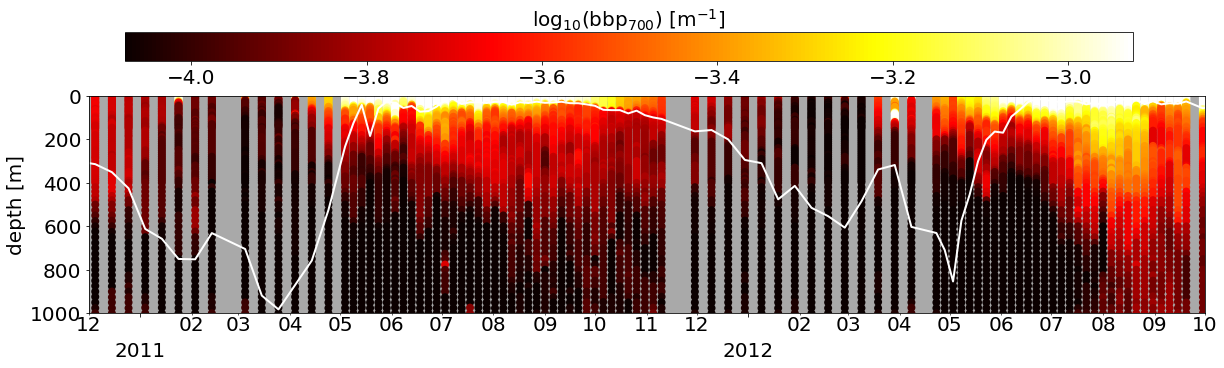

In [43]:
# cmap = cmocean.cm.tempo_r
# cmap = mpl.cm.RdYlBu
# cmap = mpl.cm.RdYlBu_r
# cmap = mpl.cm.jet
# cmap = mpl.cm.magma
cmap = mpl.cm.hot


vmin = np.percentile(z, 15) # "min color range"
vmax = np.percentile(z, 95) 
ymax = 1000 # depth max to plot
title = '$\log_{10}$(bbp$_{700}$) [m$^{-1}$]'

# see matplotlib tuto at https://matplotlib.org/3.3.2/tutorials/introductory/usage.html

fig, ax = plt.subplots(figsize=(20, 4)) # Create a figure containing a single axes.
ax.set_facecolor('darkgrey')
# fig = plt.figure(1, figsize=(20, 6))
# ax = fig.add_subplot(111, axisbg='#E6E6E6')
ax.scatter(x, y, s=64, c=z, marker='o', edgecolors='none', vmin=vmin, vmax=vmax, cmap=cmap) # Plot data on the axes.
ax.set_ylabel('depth [m]', fontsize = 20)
#ax.set_title(title, fontsize = 20)
ylim([0, ymax])
plt.gca().invert_yaxis()

#####   set ticks and  labels
months = mdates.MonthLocator(interval=1)
years = mdates.YearLocator() 

datemin = datetime.strptime('2010-12-01', '%Y-%m-%d').date()
datemin = datemin.toordinal()
datemax = datetime.strptime('2012-10-01', '%Y-%m-%d').date()
datemax = datemax.toordinal()

ax.set_xlim(datemin, datemax)

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_locator(years)
fmt = mdates.DateFormatter('%m')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(fmt)

ax.tick_params(axis='x', which='major', direction='out', pad=25, labelsize=20)
ax.tick_params(axis='x', which='minor', direction='out', pad=0.5, labelsize=20)
ax.tick_params(axis='both', which='both', labelsize=20)

# add mld data
mld = np.array(data[['MLD', 'human_time']].drop_duplicates().MLD)
time_mld = np.array(data[['MLD', 'human_time']].drop_duplicates().human_time)
ax.plot(time_mld, mld, 'w-', lw = 2)

# add colorbar
ax1 = fig.add_axes([0.15, 1, .7, .1]) # left (+ for left), up (+ for up), length, thickness

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                       norm=norm,
                       orientation='horizontal')

cb1.ax.set_title(title, fontsize = 20)
cb1.ax.tick_params(labelsize=20) 

imaxes = gca()
axes(cb1.ax)
axes(imaxes)

In [44]:
fname = 'figs/Fig2_'+str(wmo)    
fig.set_size_inches(20, 6)
fig.savefig(fname, dpi = 75)

# What about Fig. 3?

In [45]:
data.columns

Index(['depth', 'depth_qc', 'temp', 'temp_qc', 'psal', 'psal_qc', 'chla',
       'chla_qc', 'bbp', 'bbp_qc', 'time', 'lat', 'lon', 'wmo', 'id',
       'human_time', 'sigma', 'MLD', 'poc', 'z_eu', 'z_p', 'iPOC_0_1000',
       'iPOC_0_zp', 'iPOC_zp_1000', 'iPOC_zp+zi50_1000', 'iPOC_zp+zi100_1000',
       'iPOC_zp+zi200_1000', 'iPOC_zp+zi300_1000', 'iPOC_zp+zi400_1000'],
      dtype='object')

In [46]:
data2 = data[['human_time', 'iPOC_0_1000', 'iPOC_0_zp','iPOC_zp_1000','iPOC_zp+zi50_1000',
             'iPOC_zp+zi100_1000', 'iPOC_zp+zi200_1000', 'iPOC_zp+zi300_1000', 'iPOC_zp+zi400_1000',
             'MLD', 'id']].drop_duplicates()
data2

,human_time,iPOC_0_1000,iPOC_0_zp,iPOC_zp_1000,iPOC_zp+zi50_1000,iPOC_zp+zi100_1000,iPOC_zp+zi200_1000,iPOC_zp+zi300_1000,iPOC_zp+zi400_1000,MLD,id
1,2010-11-05,6.138665,2.470648,3.56042,3.08334,2.67334,1.90853,1.40752,1.06212,201.725404,1
684,2010-11-15,5.255611,2.411398,2.76547,2.45936,2.13946,1.50754,1.1345,0.847238,281.358714,2
1367,2010-11-25,5.040070,2.385213,2.58683,2.27626,1.91267,1.41343,1.03546,0.730315,301.545497,3
2051,2010-12-05,4.463026,2.230653,2.16657,1.8772,1.58879,1.07221,0.763475,0.543863,314.122374,4
2734,2010-12-15,4.546678,2.290012,2.19326,1.82006,1.5783,1.08691,0.789408,0.557098,350.951504,5
...,...,...,...,...,...,...,...,...,...,...,...
103135,2013-08-31,6.327355,2.026027,4.1104,3.68378,3.28368,2.59611,1.95257,1.45087,35.718331,152
103818,2013-09-05,7.516922,3.203918,4.0899,3.70256,3.28856,2.65797,2.05654,1.51174,48.234464,153
104501,2013-09-10,7.682400,3.344591,4.02702,3.59928,3.23418,2.58288,1.98437,1.54687,48.697659,154
105184,2013-09-15,7.570684,3.504290,3.76046,3.41486,3.12848,2.4594,1.84033,1.36405,47.933889,155


In [47]:
# remove NaN otherwise matplotlib will not work. It should only concerns stocks that are NaN which is the same as 0
data2 = data2.replace('NaN', 0)

# # data to plot
# x = np.array(data2['human_time'])
# iPOC_0_1000 = np.array(data2['iPOC_0_1000'])
# iPOC_0_zp = np.array(data2['iPOC_0_zp'])
# iPOC_zp_1000 = np.array(data2['iPOC_zp_1000'])
# iPOC_zpzi50_1000 = np.array(data2['iPOC_zp+zi50_1000'])
# iPOC_zpzi100_1000 = np.array(data2['iPOC_zp+zi100_1000'])
# iPOC_zpzi200_1000 = np.array(data2['iPOC_zp+zi200_1000'])
# iPOC_zpzi300_1000 = np.array(data2['iPOC_zp+zi300_1000'])
# iPOC_zpzi400_1000 = np.array(data2['iPOC_zp+zi400_1000'])

# # add MLD data
# mld = np.array(data2['MLD'])
# time_mld = np.array(data2['human_time'])

In [48]:
def fastsmooth(Y, smoothwidth):
    w = round(smoothwidth)
    SumPoints = np.sum(Y[0:w])
    s = np.zeros(size(Y))
    halfw = int(np.round(w/2))
    L = len(Y)
    
    for k in range(0,L-w):
        s[k+halfw-1] = SumPoints
        SumPoints = SumPoints - Y[k]
        SumPoints = SumPoints + Y[k+w]
    
    s[k+halfw] = np.sum(Y[L-w:L])
    SmoothY = s/w
    startpoint = int((smoothwidth+1)/2)
    SmoothY[0] = (Y[0] + Y[1])/2
    #return(SmoothY)
    
    L = len(SmoothY) - 1 # due to the conversion from octave to python (1-indexing VS 0-indexing)
    for k in range(2,startpoint): # for some reason, it worked w/ range starting at 2, not at 1..
        SmoothY[k] = mean(Y[1:(2*k-1)])
        SmoothY[L-k+1] = mean(Y[L-2*k+2:L])

    SmoothY[L]=(Y[L]+Y[L-1])/2
    
    return(SmoothY)

def pseudo_gauss_filt(y, w):
    y1 = fastsmooth(y, w)
    y2 = fastsmooth(y1, w)
    y3 = fastsmooth(y2, w)
    return(y3)

In [49]:
# sns.palplot(sns.light_palette("grey", reverse=True))

In [50]:
import seaborn as sns
pal = sns.light_palette("grey", reverse=True)
pal = sns.dark_palette("green", reverse=True)

In [51]:
# fig, ax = plt.subplots(figsize = (20,6))
# ax2 = ax.twinx()
# w = 5

# #ax.plot(x, iPOC_0_1000) # Plot data on the axes.
# # ax.bar(x, iPOC_zp_1000, width = w, color = pal[0])
# # ax.bar(x, iPOC_zpzi50_1000, width = w, color = pal[1])
# # ax.bar(x, iPOC_zpzi100_1000, width = w, color = pal[2])
# # ax.bar(x, iPOC_zpzi200_1000, width = w, color = pal[3])
# # ax.bar(x, iPOC_zpzi300_1000, width = w, color = pal[4])
# # ax.bar(x, iPOC_zpzi400_1000, width = w, color = pal[5])

# ax.bar(x, iPOC_zp_1000, width = w, color = pal[5])
# ax.bar(x, iPOC_zpzi50_1000, width = w, color = pal[4])
# ax.bar(x, iPOC_zpzi100_1000, width = w, color = pal[3])
# ax.bar(x, iPOC_zpzi200_1000, width = w, color = pal[2])
# ax.bar(x, iPOC_zpzi300_1000, width = w, color = pal[1])
# ax.bar(x, iPOC_zpzi400_1000, width = w, color = pal[0])

# # iPOC in the upper layer
# # from scipy.ndimage import gaussian_filter1d
# #iPOC_0_zp_s = gaussian_filter1d(iPOC_0_zp, 1) # smoothed
# iPOC_0_zp_s = pseudo_gauss_filt(iPOC_0_zp, 15)
# ax.plot(x, iPOC_0_zp_s, color = 'red', lw = 2)
# ax.bar(x, iPOC_0_zp, width = w, color = "None", edgecolor = 'red')

# ax.set_ylabel('iPOC [g POC m$^{-2}$]', fontsize = 20)

# # iPOC zp -> 1000
# #iPOC_zp_1000_s = gaussian_filter1d(iPOC_zp_1000, 1) # smoothed
# iPOC_zp_1000_s = pseudo_gauss_filt(iPOC_zp_1000, 15)
# ax.plot(x, iPOC_zp_1000_s, color = 'black', lw = 2)

# # add (not smoothed) iPOC_0_1000
# # Shade the area between y1 and line y=0

# # try to smooth iPOC_0_1000
# #from scipy.signal import savgol_filter
# # iPOC_0_1000_s = savgol_filter(iPOC_0_1000, 15, 3)
# # iPOC_0_1000_s = signal.medfilt(iPOC_0_1000, 11)
# #from scipy.ndimage import gaussian_filter1d
# #iPOC_0_1000_s = gaussian_filter1d(iPOC_0_1000, 1)
# iPOC_0_1000_s = pseudo_gauss_filt(iPOC_0_1000, 15)
# ax.fill_between(x, y1 = iPOC_0_1000_s, facecolor="yellow", alpha=.5) # The outline color

# # import seaborn as sns
# # seq_col_brew = sns.color_palette("gray", 5)
# # sns.set_palette(seq_col_brew)

# # ax.set_title(title, fontsize = 20)
# # ylim([0, ymax])
# # plt.gca().invert_yaxis()

# #####   set ticks and  labels
# months = mdates.MonthLocator(interval=1)
# years = mdates.YearLocator() 

# datemin = datetime.strptime('2010-12-01', '%Y-%m-%d').date()
# datemin = datemin.toordinal()
# datemax = datetime.strptime('2012-10-01', '%Y-%m-%d').date()
# datemax = datemax.toordinal()

# ax.set_xlim(datemin, datemax)

# ax.xaxis.set_minor_locator(months)
# ax.xaxis.set_major_locator(years)
# fmt = mdates.DateFormatter('%m')

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# ax.xaxis.set_minor_formatter(fmt)

# ax.tick_params(axis='x', which='major', direction='out', pad=25, labelsize=20)
# ax.tick_params(axis='x', which='minor', direction='out', pad=0.5, labelsize=20)
# ax.tick_params(axis='both', which='both', labelsize=20)

# # add mld data (on another axes)
# ax2.plot(time_mld, mld, 'b--', lw = 2)
# ax2.set_ylabel('MLD [m]', fontsize = 20)
# plt.gca().invert_yaxis()

# fname = 'figs/Fig3up_'+str(wmo)    
# fig.set_size_inches(20, 6)
# fig.savefig(fname, dpi = 75)

# Compute instantaneous fluxes (reminder : hyp that flux is 0 at 1000 m)

In [52]:
# interpolation of carbon stocks on a daily basis
data_interp = data2[['human_time', 'iPOC_0_1000', 'iPOC_0_zp','iPOC_zp_1000','iPOC_zp+zi50_1000',
             'iPOC_zp+zi100_1000', 'iPOC_zp+zi200_1000', 'iPOC_zp+zi300_1000', 'iPOC_zp+zi400_1000']]
data_interp

,human_time,iPOC_0_1000,iPOC_0_zp,iPOC_zp_1000,iPOC_zp+zi50_1000,iPOC_zp+zi100_1000,iPOC_zp+zi200_1000,iPOC_zp+zi300_1000,iPOC_zp+zi400_1000
1,2010-11-05,6.138665,2.470648,3.560415,3.083341,2.673337,1.908534,1.407523,1.062120
684,2010-11-15,5.255611,2.411398,2.765472,2.459361,2.139457,1.507542,1.134501,0.847238
1367,2010-11-25,5.040070,2.385213,2.586827,2.276258,1.912669,1.413431,1.035457,0.730315
2051,2010-12-05,4.463026,2.230653,2.166571,1.877197,1.588789,1.072207,0.763475,0.543863
2734,2010-12-15,4.546678,2.290012,2.193255,1.820061,1.578304,1.086914,0.789408,0.557098
...,...,...,...,...,...,...,...,...,...
103135,2013-08-31,6.327355,2.026027,4.110399,3.683783,3.283679,2.596108,1.952570,1.450871
103818,2013-09-05,7.516922,3.203918,4.089903,3.702558,3.288557,2.657970,2.056540,1.511736
104501,2013-09-10,7.682400,3.344591,4.027019,3.599279,3.234180,2.582883,1.984366,1.546871
105184,2013-09-15,7.570684,3.504290,3.760457,3.414865,3.128480,2.459399,1.840332,1.364048


In [53]:
# interpolation of carbon stocks on a daily basis
dat = data_interp.copy()
dat['human_time'] = pd.to_datetime(dat['human_time'])
dat = dat.set_index('human_time')
#test2 = test[['iPOC_0_1000', 'iPOC_0_zp']]
dat = dat.resample('D')

In [54]:
interpolated = dat.interpolate(method='time')
interpolated.reset_index(inplace=True)
interpolated

,human_time,iPOC_0_1000,iPOC_0_zp,iPOC_zp_1000,iPOC_zp+zi50_1000,iPOC_zp+zi100_1000,iPOC_zp+zi200_1000,iPOC_zp+zi300_1000,iPOC_zp+zi400_1000
0,2010-11-05,6.138665,2.470648,3.560415,3.083341,2.673337,1.908534,1.407523,1.062120
1,2010-11-06,6.050359,2.464723,3.480921,3.020943,2.619949,1.868435,1.380220,1.040632
2,2010-11-07,5.962054,2.458798,3.401427,2.958545,2.566561,1.828336,1.352918,1.019144
3,2010-11-08,5.873748,2.452873,3.321932,2.896147,2.513173,1.788237,1.325616,0.997656
4,2010-11-09,5.785443,2.446948,3.242438,2.833749,2.459785,1.748137,1.298314,0.976168
...,...,...,...,...,...,...,...,...,...
1046,2013-09-16,7.220832,3.080527,3.826249,3.423346,3.122389,2.458842,1.847055,1.386679
1047,2013-09-17,6.870979,2.656763,3.892041,3.431827,3.116298,2.458285,1.853778,1.409309
1048,2013-09-18,6.521127,2.232999,3.957833,3.440308,3.110207,2.457729,1.860502,1.431940
1049,2013-09-19,6.171275,1.809235,4.023625,3.448790,3.104116,2.457172,1.867225,1.454570


In [55]:
def compute_flux(dataset, var_name):
    fluxes = []
    
    for i in range(dataset.shape[0]):
        if(i == 0): 
            fluxes.append(0)
        else:
            deltaIPOC = dataset.iloc[i].loc[var_name] - dataset.iloc[i-1].loc[var_name]
            deltaT = relativedelta(dataset.iloc[i].loc['human_time'], dataset.iloc[i-1].loc['human_time']) # this is not needed anymore if we have smoothed the signal on a daily resolution
            deltaT = deltaT.days
            #print(deltaT)
            flux = (deltaIPOC/deltaT)*1000 # *100 to get mg instead of g
            fluxes.append(flux)
    return(fluxes)

In [56]:
#data3 = data2.copy()
data3 = interpolated.copy() # comment here if you don't want interpolation on a daily basis
#tmp = gaussian_filter1d(data3['iPOC_0_zp'], 1) # smoothed
tmp = pseudo_gauss_filt(np.array(data3['iPOC_0_zp']), 15)
data3['iPOC_0_zp_s'] = tmp # smoothed
data3['flux_0_zp'] = compute_flux(data3, 'iPOC_0_zp_s') 

# other
#tmp = gaussian_filter1d(data3['iPOC_zp+zi50_1000'],1)
tmp = pseudo_gauss_filt(np.array(data3['iPOC_zp+zi50_1000']), 15)
data3['iPOC_zp+zi50_1000_s'] = tmp
data3['flux_zpzi50_1000'] = compute_flux(data3, 'iPOC_zp+zi50_1000_s')

# other
#tmp = gaussian_filter1d(data3['iPOC_zp+zi100_1000'],1)
tmp = pseudo_gauss_filt(np.array(data3['iPOC_zp+zi100_1000']), 15)
data3['iPOC_zp+zi100_1000_s'] = tmp
data3['flux_zpzi100_1000'] = compute_flux(data3, 'iPOC_zp+zi100_1000_s')

# other
#tmp = gaussian_filter1d(data3['iPOC_zp+zi200_1000'],1)
tmp = pseudo_gauss_filt(np.array(data3['iPOC_zp+zi200_1000']), 15)
data3['iPOC_zp+zi200_1000_s'] = tmp
data3['flux_zpzi200_1000'] = compute_flux(data3, 'iPOC_zp+zi200_1000_s')

# other
#tmp = gaussian_filter1d(data3['iPOC_zp+zi300_1000'],1)
tmp = pseudo_gauss_filt(np.array(data3['iPOC_zp+zi300_1000']), 15)
data3['iPOC_zp+zi300_1000_s'] = tmp
data3['flux_zpzi300_1000'] = compute_flux(data3, 'iPOC_zp+zi300_1000_s')

#tmp = gaussian_filter1d(data3['iPOC_zp+zi400_1000'],1)
tmp = pseudo_gauss_filt(np.array(data3['iPOC_zp+zi400_1000']), 15)
data3['iPOC_zp+zi400_1000_s'] = tmp
data3['flux_zpzi400_1000'] = compute_flux(data3, 'iPOC_zp+zi400_1000_s')

In [57]:
# data to plot
x = np.array(data3['human_time'])
flux_zpzi50_1000 = np.array(data3['flux_zpzi50_1000'])
flux_zpzi100_1000 = np.array(data3['flux_zpzi100_1000'])
flux_zpzi200_1000 = np.array(data3['flux_zpzi200_1000'])
flux_zpzi300_1000 = np.array(data3['flux_zpzi300_1000'])
flux_zpzi400_1000 = np.array(data3['flux_zpzi400_1000'])
flux_0_zp = np.array(data3['flux_0_zp'])

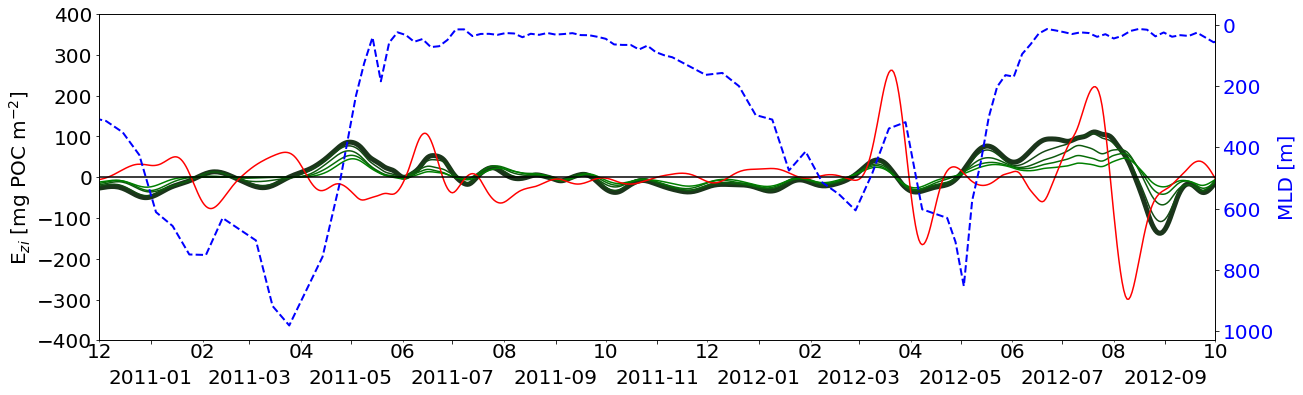

In [58]:
fig, ax = plt.subplots(figsize = (20,6))
ax2 = ax.twinx()

ax.plot(x, flux_zpzi50_1000, color = pal[4], linewidth = 5)
ax.plot(x, flux_zpzi100_1000, color = pal[3])
ax.plot(x, flux_zpzi200_1000, color = pal[2])
ax.plot(x, flux_zpzi300_1000, color = pal[1])
ax.plot(x, flux_zpzi400_1000, color = pal[0])
ax.plot(x, flux_0_zp, color = 'red')

ax.set_ylim(-400, 400)
ax.set_ylabel('E$_{zi}$ [mg POC m$^{-2}$]', fontsize = 20)

#####   set ticks and  labels
months = mdates.MonthLocator(interval=1)
years = mdates.YearLocator() 

datemin = datetime.strptime('2010-12-01', '%Y-%m-%d').date()
datemin = datemin.toordinal()
datemax = datetime.strptime('2012-10-01', '%Y-%m-%d').date()
datemax = datemax.toordinal()

ax.set_xlim(datemin, datemax)

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_locator(years)
fmt = mdates.DateFormatter('%m')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(fmt)

ax.tick_params(axis='x', which='major', direction='out', pad=25, labelsize=20)
ax.tick_params(axis='x', which='minor', direction='out', pad=0.5, labelsize=20)
ax.tick_params(axis='both', which='both', labelsize=20)

# add mld data (on another axes)
ax2.plot(time_mld, mld, 'b--', lw = 2)
ax2.set_ylabel('MLD [m]', fontsize = 20)
ax2.tick_params(labelcolor = 'blue', labelsize = 20)
ax2.yaxis.label.set_color('blue')
plt.gca().invert_yaxis()

# add horizontal line
ax.axhline(y = 0, color = 'black')

fname = 'figs/Fig3down_'+str(wmo)    
fig.set_size_inches(20, 6)
fig.savefig(fname, dpi = 75)

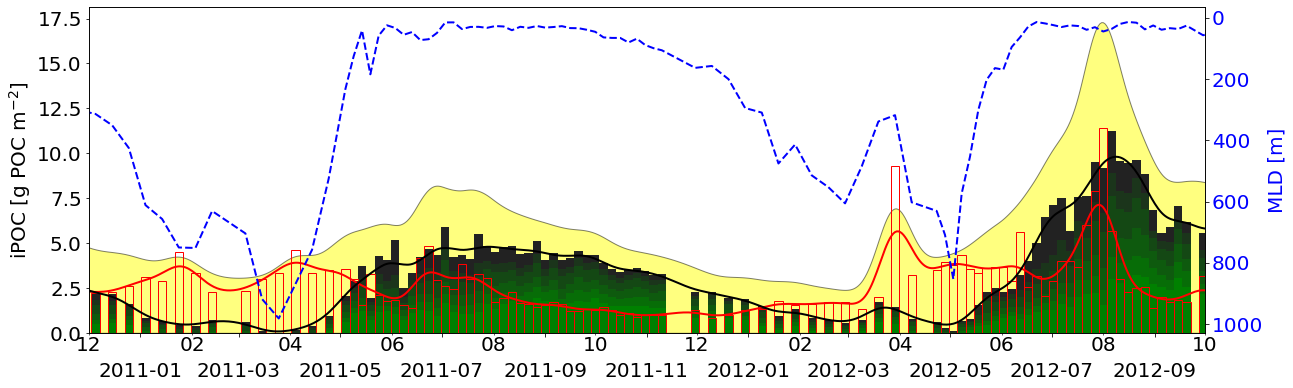

In [59]:
fig, ax = plt.subplots(figsize = (20,6))
ax2 = ax.twinx()
w = 5

# data to plot (NOT INTERPOLATED)
x = np.array(data2['human_time'])
iPOC_0_1000 = np.array(data2['iPOC_0_1000'])
iPOC_0_zp = np.array(data2['iPOC_0_zp'])
iPOC_zp_1000 = np.array(data2['iPOC_zp_1000'])
iPOC_zpzi50_1000 = np.array(data2['iPOC_zp+zi50_1000'])
iPOC_zpzi100_1000 = np.array(data2['iPOC_zp+zi100_1000'])
iPOC_zpzi200_1000 = np.array(data2['iPOC_zp+zi200_1000'])
iPOC_zpzi300_1000 = np.array(data2['iPOC_zp+zi300_1000'])
iPOC_zpzi400_1000 = np.array(data2['iPOC_zp+zi400_1000'])

# add MLD data
mld = np.array(data2['MLD'])
time_mld = np.array(data2['human_time'])

ax.bar(x, iPOC_zp_1000, width = w, color = pal[5])
ax.bar(x, iPOC_zpzi50_1000, width = w, color = pal[4])
ax.bar(x, iPOC_zpzi100_1000, width = w, color = pal[3])
ax.bar(x, iPOC_zpzi200_1000, width = w, color = pal[2])
ax.bar(x, iPOC_zpzi300_1000, width = w, color = pal[1])
ax.bar(x, iPOC_zpzi400_1000, width = w, color = pal[0])

# iPOC in the upper layer
# from scipy.ndimage import gaussian_filter1d
#iPOC_0_zp_s = gaussian_filter1d(iPOC_0_zp, 1) # smoothed
#iPOC_0_zp_s = pseudo_gauss_filt(iPOC_0_zp, 15)
time_s = np.array(data3['human_time'])
iPOC_0_zp_s = np.array(data3['iPOC_0_zp_s'])
ax.plot(time_s , iPOC_0_zp_s, color = 'red', lw = 2)
ax.bar(x, iPOC_0_zp, width = w, color = "None", edgecolor = 'red')

ax.set_ylabel('iPOC [g POC m$^{-2}$]', fontsize = 20)

# iPOC zp -> 1000
#iPOC_zp_1000_s = gaussian_filter1d(iPOC_zp_1000, 1) # smoothed
#iPOC_zp_1000_s = pseudo_gauss_filt(iPOC_zp_1000, 15)
#iPOC_zp_1000_s = np.array(data3['iPOC_zp_1000'])
iPOC_zp_1000_s = pseudo_gauss_filt(np.array(data3['iPOC_zp_1000']), 15) # because it was not smoothed before
ax.plot(time_s, iPOC_zp_1000_s, color = 'black', lw = 2)

# add (not smoothed) iPOC_0_1000
# Shade the area between y1 and line y=0

# try to smooth iPOC_0_1000
#from scipy.signal import savgol_filter
# iPOC_0_1000_s = savgol_filter(iPOC_0_1000, 15, 3)
# iPOC_0_1000_s = signal.medfilt(iPOC_0_1000, 11)
#from scipy.ndimage import gaussian_filter1d
#iPOC_0_1000_s = gaussian_filter1d(iPOC_0_1000, 1)
#iPOC_0_1000_s = pseudo_gauss_filt(iPOC_0_1000, 15)
iPOC_0_1000_s = pseudo_gauss_filt(np.array(data3['iPOC_0_1000']), 15)
ax.fill_between(time_s, iPOC_0_1000_s, facecolor="yellow", edgecolor = "black", alpha=.5) # The outline color

# import seaborn as sns
# seq_col_brew = sns.color_palette("gray", 5)
# sns.set_palette(seq_col_brew)

# ax.set_title(title, fontsize = 20)
# ylim([0, ymax])
# plt.gca().invert_yaxis()

#####   set ticks and  labels
months = mdates.MonthLocator(interval=1)
years = mdates.YearLocator() 

datemin = datetime.strptime('2010-12-01', '%Y-%m-%d').date()
datemin = datemin.toordinal()
datemax = datetime.strptime('2012-10-01', '%Y-%m-%d').date()
datemax = datemax.toordinal()

ax.set_xlim(datemin, datemax)

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_locator(years)
fmt = mdates.DateFormatter('%m')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(fmt)

ax.tick_params(axis='x', which='major', direction='out', pad=25, labelsize=20)
ax.tick_params(axis='x', which='minor', direction='out', pad=0.5, labelsize=20)
ax.tick_params(axis='both', which='both', labelsize=20)

# add mld data (on another axes)
ax2.plot(time_mld, mld, 'b--', lw = 2)
ax2.set_ylabel('MLD [m]', fontsize = 20)
ax2.tick_params(labelcolor = 'blue', labelsize = 20)
ax2.yaxis.label.set_color('blue')
plt.gca().invert_yaxis()

fname = 'figs/Fig3up_'+str(wmo)    
fig.set_size_inches(20, 6)
fig.savefig(fname, dpi = 75)

In [60]:
# compute seasonal E_0
def compute_seasonal_E0(data3):
    

    # for 2011
    tmp2011 = data3[(data3.human_time < "2011-11-01") & (data3.human_time > "2011-01-01")]
    #tmp2011
    # time_min = tmp2011.iloc[np.argmin(tmp2011['iPOC_zp_1000'])].loc['human_time']
    # value_min = tmp2011.iloc[np.argmin(tmp2011['iPOC_zp_1000'])].loc['iPOC_zp_1000']
    # time_max = tmp2011.iloc[np.argmax(tmp2011['iPOC_zp_1000'])].loc['human_time']
    # value_max = tmp2011.iloc[np.argmax(tmp2011['iPOC_zp_1000'])].loc['iPOC_zp_1000']
    index_min = np.argmin(tmp2011['iPOC_zp_1000'])
    index_max = np.argmax(tmp2011['iPOC_zp_1000'])
    
    tmp2011 = tmp2011.iloc[index_min:index_max+1][['human_time','iPOC_zp_1000']]
    #tmp2011
    
    # regression
    from sklearn.linear_model import LinearRegression
    import datetime as dt
    #https://stackoverflow.com/questions/40217369/python-linear-regression-predict-by-date
    tmp2011['time_ordinal'] = tmp2011['human_time'].map(dt.datetime.toordinal)
    X = np.array(tmp2011['time_ordinal']).reshape((-1, 1))
    y = np.array(tmp2011['iPOC_zp_1000'])
    yfit = LinearRegression().fit(X,y)
    fit2011 = yfit.coef_*X+yfit.intercept_
    fit2011 = pd.DataFrame({'human_time':tmp2011['human_time'], 'fitted':np.concatenate(fit2011)})
    
    # for 2012
    tmp2012 = data3[(data3.human_time < "2012-11-01") & (data3.human_time > "2012-01-01")]
    #tmp2011
    # time_min = tmp2011.iloc[np.argmin(tmp2011['iPOC_zp_1000'])].loc['human_time']
    # value_min = tmp2011.iloc[np.argmin(tmp2011['iPOC_zp_1000'])].loc['iPOC_zp_1000']
    # time_max = tmp2011.iloc[np.argmax(tmp2011['iPOC_zp_1000'])].loc['human_time']
    # value_max = tmp2011.iloc[np.argmax(tmp2011['iPOC_zp_1000'])].loc['iPOC_zp_1000']
    index_min = np.argmin(tmp2012['iPOC_zp_1000'])
    index_max = np.argmax(tmp2012['iPOC_zp_1000'])
    
    tmp2012 = tmp2012.iloc[index_min:index_max+1][['human_time','iPOC_zp_1000']]
    tmp2012['time_ordinal'] = tmp2012['human_time'].map(dt.datetime.toordinal)
    X = np.array(tmp2012['time_ordinal']).reshape((-1, 1))
    y = np.array(tmp2012['iPOC_zp_1000'])
    yfit = LinearRegression().fit(X,y)
    fit2012 = yfit.coef_*X+yfit.intercept_
    fit2012 = pd.DataFrame({'human_time':tmp2012['human_time'], 'fitted':np.concatenate(fit2012)})
    
    
    return(fit2011, fit2012)

In [61]:
season2011, season2012 = compute_seasonal_E0(data3)

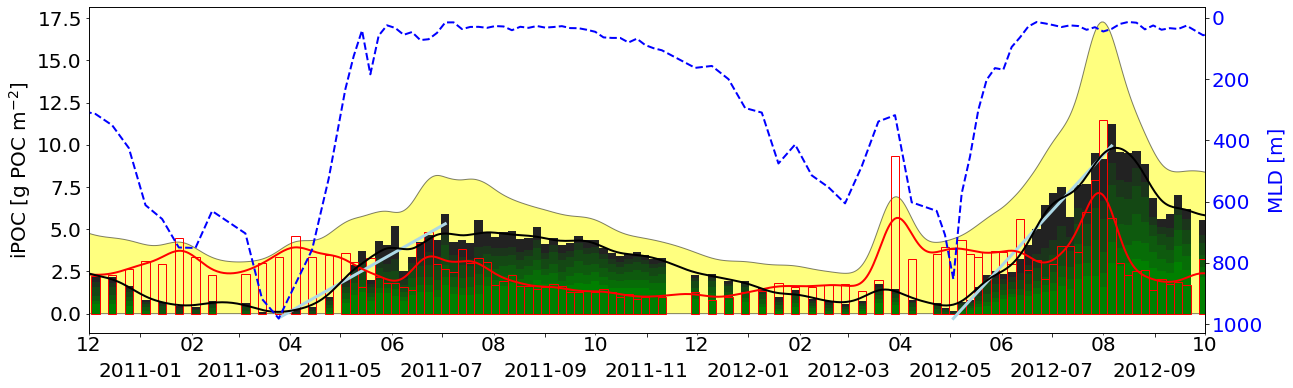

In [62]:
fig, ax = plt.subplots(figsize = (20,6))
ax2 = ax.twinx()
w = 5

# data to plot (NOT INTERPOLATED)
x = np.array(data2['human_time'])
iPOC_0_1000 = np.array(data2['iPOC_0_1000'])
iPOC_0_zp = np.array(data2['iPOC_0_zp'])
iPOC_zp_1000 = np.array(data2['iPOC_zp_1000'])
iPOC_zpzi50_1000 = np.array(data2['iPOC_zp+zi50_1000'])
iPOC_zpzi100_1000 = np.array(data2['iPOC_zp+zi100_1000'])
iPOC_zpzi200_1000 = np.array(data2['iPOC_zp+zi200_1000'])
iPOC_zpzi300_1000 = np.array(data2['iPOC_zp+zi300_1000'])
iPOC_zpzi400_1000 = np.array(data2['iPOC_zp+zi400_1000'])

# add MLD data
mld = np.array(data2['MLD'])
time_mld = np.array(data2['human_time'])

ax.bar(x, iPOC_zp_1000, width = w, color = pal[5])
ax.bar(x, iPOC_zpzi50_1000, width = w, color = pal[4])
ax.bar(x, iPOC_zpzi100_1000, width = w, color = pal[3])
ax.bar(x, iPOC_zpzi200_1000, width = w, color = pal[2])
ax.bar(x, iPOC_zpzi300_1000, width = w, color = pal[1])
ax.bar(x, iPOC_zpzi400_1000, width = w, color = pal[0])

# add seasonal E0
ax.plot(np.array(season2011['human_time']), np.array(season2011['fitted']), linewidth = 3, color = "lightblue")
ax.plot(np.array(season2012['human_time']), np.array(season2012['fitted']), linewidth = 3, color = "lightblue")

# iPOC in the upper layer
# from scipy.ndimage import gaussian_filter1d
#iPOC_0_zp_s = gaussian_filter1d(iPOC_0_zp, 1) # smoothed
#iPOC_0_zp_s = pseudo_gauss_filt(iPOC_0_zp, 15)
time_s = np.array(data3['human_time'])
iPOC_0_zp_s = np.array(data3['iPOC_0_zp_s'])
ax.plot(time_s , iPOC_0_zp_s, color = 'red', lw = 2)
ax.bar(x, iPOC_0_zp, width = w, color = "None", edgecolor = 'red')

ax.set_ylabel('iPOC [g POC m$^{-2}$]', fontsize = 20)

# iPOC zp -> 1000
#iPOC_zp_1000_s = gaussian_filter1d(iPOC_zp_1000, 1) # smoothed
#iPOC_zp_1000_s = pseudo_gauss_filt(iPOC_zp_1000, 15)
#iPOC_zp_1000_s = np.array(data3['iPOC_zp_1000'])
iPOC_zp_1000_s = pseudo_gauss_filt(np.array(data3['iPOC_zp_1000']), 15) # because it was not smoothed before
ax.plot(time_s, iPOC_zp_1000_s, color = 'black', lw = 2)

# add (not smoothed) iPOC_0_1000
# Shade the area between y1 and line y=0

# try to smooth iPOC_0_1000
#from scipy.signal import savgol_filter
# iPOC_0_1000_s = savgol_filter(iPOC_0_1000, 15, 3)
# iPOC_0_1000_s = signal.medfilt(iPOC_0_1000, 11)
#from scipy.ndimage import gaussian_filter1d
#iPOC_0_1000_s = gaussian_filter1d(iPOC_0_1000, 1)
#iPOC_0_1000_s = pseudo_gauss_filt(iPOC_0_1000, 15)
iPOC_0_1000_s = pseudo_gauss_filt(np.array(data3['iPOC_0_1000']), 15)
ax.fill_between(time_s, iPOC_0_1000_s, facecolor="yellow", edgecolor = "black", alpha=.5) # The outline color

# import seaborn as sns
# seq_col_brew = sns.color_palette("gray", 5)
# sns.set_palette(seq_col_brew)

# ax.set_title(title, fontsize = 20)
# ylim([0, ymax])
# plt.gca().invert_yaxis()

#####   set ticks and  labels
months = mdates.MonthLocator(interval=1)
years = mdates.YearLocator() 

datemin = datetime.strptime('2010-12-01', '%Y-%m-%d').date()
datemin = datemin.toordinal()
datemax = datetime.strptime('2012-10-01', '%Y-%m-%d').date()
datemax = datemax.toordinal()

ax.set_xlim(datemin, datemax)

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_locator(years)
fmt = mdates.DateFormatter('%m')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(fmt)

ax.tick_params(axis='x', which='major', direction='out', pad=25, labelsize=20)
ax.tick_params(axis='x', which='minor', direction='out', pad=0.5, labelsize=20)
ax.tick_params(axis='both', which='both', labelsize=20)

# add mld data (on another axes)
ax2.plot(time_mld, mld, 'b--', lw = 2)
ax2.set_ylabel('MLD [m]', fontsize = 20)
ax2.tick_params(labelcolor = 'blue', labelsize = 20)
ax2.yaxis.label.set_color('blue')
plt.gca().invert_yaxis()

fname = 'figs/Fig3up_'+str(wmo)    
fig.set_size_inches(20, 6)
fig.savefig(fname, dpi = 75)

# TO DO
- 1. compute the depth of the bottom of the euphotic zone (3 différents ways possible but two to really compare) => needs to be discussed and tested with the method of Lionel for the determination of z_eu
- 2. finalize the check for no POC at 1000m